# **KASDD F1 Lap time - Biasa Aja**

# Import Dataset

### **Sumber**
> https://www.datacamp.com/tutorial/random-forests-classifier-python <br>
> https://www.freecodecamp.org/news/how-to-use-the-tree-based-algorithm-for-machine-learning/ <br>
> https://forecastegy.com/posts/does-random-forest-need-feature-scaling-or-normalization/#:~:text=If%20you%20are%20using%20Random,does%20not%20require%20feature%20scaling. <br>
> https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648 <br>
> https://365datascience.com/tutorials/python-tutorials/pca-k-means/

In [174]:
# import library dan data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as scp
import scipy.cluster.hierarchy as shc

from decimal import Decimal
from numpy.polynomial.polynomial import polyfit
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, mutual_info_regression, mutual_info_classif, SelectKBest, mutual_info_regression, SelectPercentile, mutual_info_regression, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import RepeatedStratifiedKFold


f1_data = pd.read_csv("f1_train.csv")
f1_data = f1_data.drop(axis=1, columns=["ID"])
f1_data

,Time,LapTime,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,...,Deleted,DeletedReason,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Pos_cat
0,0 days 02:26:25.496000,0 days 00:01:40.943000,6.0,0 days 02:25:08.325000,NaN,0 days 00:00:46.163000,0 days 00:00:28.979000,0 days 00:00:25.801000,0 days 02:25:36.926000,0 days 02:26:05.905000,...,False,NaN,17.1,68.0,1008.0,False,24.8,157,3.0,Participant
1,0 days 01:13:51.732000,0 days 00:01:48.067000,1.0,NaN,NaN,0 days 00:00:39.129000,0 days 00:00:43.601000,0 days 00:00:25.337000,0 days 01:12:42.794000,0 days 01:13:26.395000,...,False,NaN,25.0,49.0,1008.5,False,43.3,275,1.0,Podium
2,0 days 02:22:35.139000,0 days 00:01:22.881000,2.0,NaN,NaN,0 days 00:00:28.890000,0 days 00:00:18.554000,0 days 00:00:35.437000,0 days 02:21:41.150000,0 days 02:21:59.704000,...,False,NaN,17.6,57.0,1018.2,False,29.9,0,0.6,Participant
3,0 days 01:03:36.822000,0 days 00:01:31.585000,1.0,0 days 00:14:44.885000,NaN,NaN,0 days 00:00:28.929000,0 days 00:00:30.478000,NaN,0 days 01:03:06.412000,...,False,NaN,17.6,67.0,1007.7,False,29.5,135,1.8,Podium
4,0 days 01:45:40.072000,0 days 00:01:34.742000,2.0,NaN,NaN,0 days 00:00:34.895000,0 days 00:00:29.874000,0 days 00:00:29.973000,0 days 01:44:40.174000,0 days 01:45:10.048000,...,False,NaN,26.1,55.0,1011.0,False,31.0,271,1.3,Point
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18783,0 days 01:27:00.913000,0 days 00:01:25.235000,2.0,NaN,NaN,0 days 00:00:30.620000,0 days 00:00:30.668000,0 days 00:00:23.947000,0 days 01:26:06.294000,0 days 01:26:36.962000,...,False,NaN,29.3,32.0,988.4,False,49.9,252,1.2,Participant
18784,0 days 01:21:32.309000,0 days 00:01:40.363000,1.0,NaN,NaN,0 days 00:00:29.488000,0 days 00:00:42.838000,0 days 00:00:28.037000,0 days 01:20:21.469000,0 days 01:21:04.307000,...,False,NaN,30.0,72.0,1009.0,False,36.8,145,1.1,Participant
18785,0 days 02:00:31.678000,0 days 00:01:52.495000,3.0,NaN,NaN,0 days 00:00:32.659000,0 days 00:00:49.567000,0 days 00:00:30.269000,0 days 01:59:11.871000,0 days 02:00:01.438000,...,False,NaN,17.6,66.0,966.7,False,30.3,146,1.1,Participant
18786,0 days 01:07:59.947000,0 days 00:01:25.938000,1.0,NaN,NaN,0 days 00:00:30.564000,0 days 00:00:31.370000,0 days 00:00:24.004000,0 days 01:07:04.556000,0 days 01:07:35.926000,...,False,NaN,28.8,33.0,988.5,False,50.1,134,1.5,Participant


In [175]:
f1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                18788 non-null  object 
 1   LapTime             18498 non-null  object 
 2   Stint               18788 non-null  float64
 3   PitOutTime          1039 non-null   object 
 4   PitInTime           735 non-null    object 
 5   Sector1Time         18381 non-null  object 
 6   Sector2Time         18749 non-null  object 
 7   Sector3Time         18696 non-null  object 
 8   Sector1SessionTime  18344 non-null  object 
 9   Sector2SessionTime  18749 non-null  object 
 10  Sector3SessionTime  18696 non-null  object 
 11  SpeedI1             15871 non-null  float64
 12  SpeedI2             18749 non-null  float64
 13  SpeedFL             18013 non-null  float64
 14  SpeedST             17096 non-null  float64
 15  IsPersonalBest      18758 non-null  object 
 16  Comp

# Preprocessing

In [176]:
def cek_duplicates(df):
    if df.duplicated().sum() > 0:
        print("Terdapat", df.duplicated().sum(), "pasang data yang redundan")
        display(df[df.duplicated()])
    else:
        print("Tidak ada data yang redundan")

def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=True)
    percent = col_na*100 / len(df)

    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    if (missing_data[missing_data['Total'] > 0].shape[0] == 0):
        print("Tidak ditemukan missing value pada dataset")

    else:
        print(missing_data[missing_data['Total'] > 0])

def cek_outlier(df):
    df_numerical = df.select_dtypes(include=['float64', 'int64']) 
    Q1 = df_numerical.quantile(0.25, numeric_only=True)
    Q3 = df_numerical.quantile(0.75, numeric_only=True)

    # Menghitung RUB dan RLB.
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Menampilkan banyaknya outlier pada atribut.
    outliers = (df_numerical < lower_limit) | (df_numerical > upper_limit)

    # Menghitung dan menampilkan persentase outlier pada tiap atribut.
    percentage_outliers = (outliers.sum() / len(df)) * 100
    print("Persentase Outlier pada tiap atribut:")
    print(percentage_outliers)

### Handling Missing Value

In [177]:
cek_null(f1_data)

                    Total    Percent
IsPersonalBest         30   0.159676
SpeedI2                39   0.207579
Sector2SessionTime     39   0.207579
Sector2Time            39   0.207579
Sector3SessionTime     92   0.489674
Sector3Time            92   0.489674
LapTime               290   1.543538
Sector1Time           407   2.166276
Sector1SessionTime    444   2.363211
SpeedFL               775   4.124973
SpeedST              1692   9.005748
SpeedI1              2917  15.525868
PitOutTime          17749  94.469874
PitInTime           18053  96.087928
DeletedReason       18477  98.344688


> Atribut `PitOutTime`, `PitInTime`, dan `DeletedReason` memiliki persentase jumlah missing value mencapai lebih dari 90%. Oleh karena itu, atribut-atribut tersebut perlu di drop.

In [178]:
f1_data = f1_data.drop(axis=1, columns=['PitOutTime', 'PitInTime', 'DeletedReason'])

In [179]:
def show_data_type_and_distribution(df):
    print("Menampilkan informasi dataset dan tipe data")
    print('#'*50)
    df.info()
    print('#'*50)
    print("Menampilkan distribusi data numerik")
    numerics = ['SpeedI2', 'SpeedFL', 'SpeedST', 'SpeedI1']
    for col in numerics:
        df_feature = f1_data[col]
        plt.figure(figsize=(10,5))
        plt.title(f'Distribusi data {col}')
        sns.kdeplot(df_feature, fill=True)
        plt.show()
    print("Menampilkan Modus dari data kategorikal")
    categoricals = ["IsPersonalBest", "Sector2SessionTime", "Sector2Time","Sector3SessionTime", "Sector3Time", "LapTime", "Sector1Time", "Sector1SessionTime"]
    for col in categoricals:
        print(f"Mode for {col} = {f1_data[col].mode()[0]}")

Menampilkan informasi dataset dan tipe data
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                18788 non-null  object 
 1   LapTime             18498 non-null  object 
 2   Stint               18788 non-null  float64
 3   Sector1Time         18381 non-null  object 
 4   Sector2Time         18749 non-null  object 
 5   Sector3Time         18696 non-null  object 
 6   Sector1SessionTime  18344 non-null  object 
 7   Sector2SessionTime  18749 non-null  object 
 8   Sector3SessionTime  18696 non-null  object 
 9   SpeedI1             15871 non-null  float64
 10  SpeedI2             18749 non-null  float64
 11  SpeedFL             18013 non-null  float64
 12  SpeedST             17096 non-null  float64
 13  IsPersonalBest      18758 non-null  object 
 14  Compoun

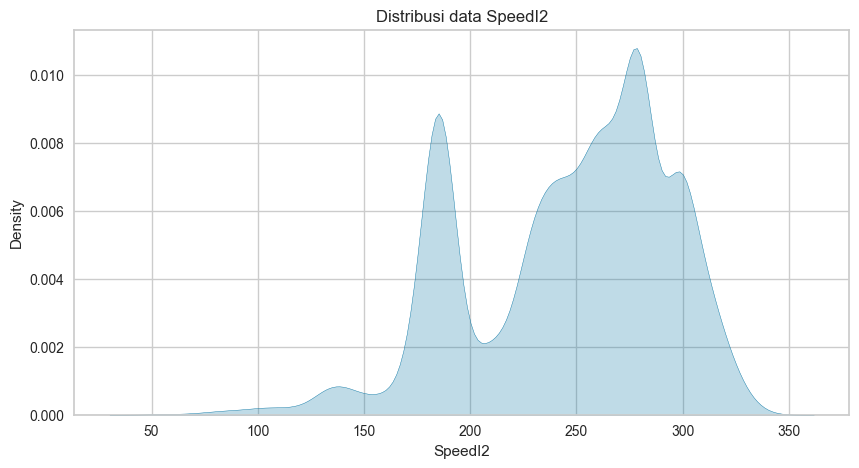

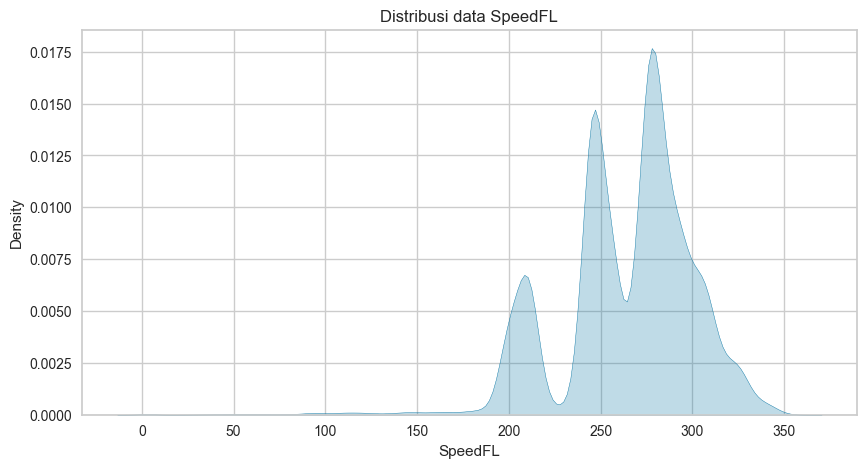

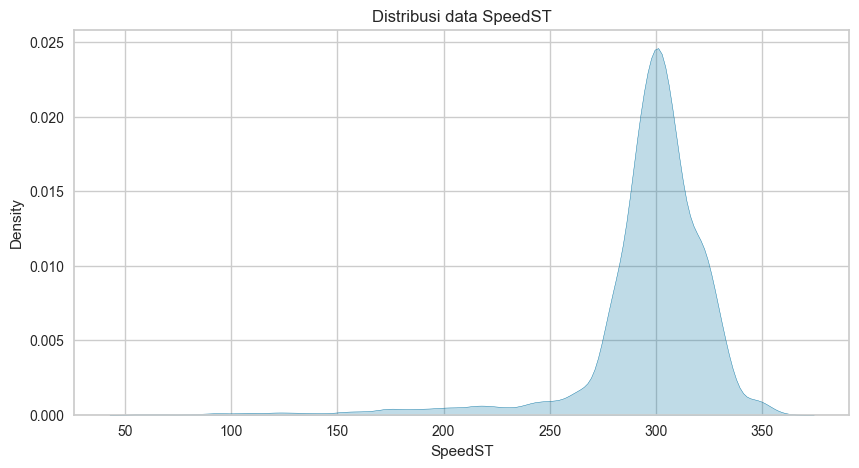

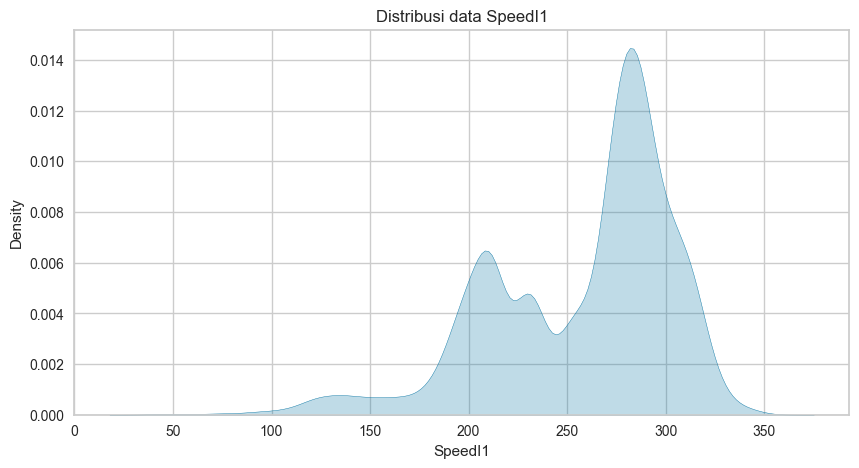

Menampilkan Modus dari data kategorikal
Mode for IsPersonalBest = False
Mode for Sector2SessionTime = 0 days 01:03:29.878000
Mode for Sector2Time = 0 days 00:00:29.905000
Mode for Sector3SessionTime = 0 days 01:06:09.122000
Mode for Sector3Time = 0 days 00:00:25.692000
Mode for LapTime = 0 days 00:01:16.993000
Mode for Sector1Time = 0 days 00:00:28.315000
Mode for Sector1SessionTime = 0 days 01:04:58.279000


In [180]:
show_data_type_and_distribution(f1_data)

In [181]:
def fill_null_mean(df):
    mean = df.mean()
    filled_df = df.fillna(mean)
    return filled_df
def fill_null_median(df):
    median = df.median()
    filled_df = df.fillna(median)
    return filled_df
def fill_null_mode(df):
    mode = df.mode()[0]
    filled_df = df.fillna(mode)
    return filled_df

In [182]:
f1_data['SpeedI2'] = fill_null_median(f1_data['SpeedI2'])
f1_data['SpeedFL'] = fill_null_median(f1_data['SpeedFL'])
f1_data['SpeedST'] = fill_null_mean(f1_data['SpeedST'])
f1_data['SpeedI1'] = fill_null_median(f1_data['SpeedI1'])
f1_data['IsPersonalBest'] = fill_null_mode(f1_data['IsPersonalBest'])
f1_data['Sector2SessionTime'] = fill_null_mode(f1_data['Sector2SessionTime'])
f1_data['Sector2Time'] = fill_null_mode(f1_data['Sector2Time'])
f1_data['Sector3SessionTime'] = fill_null_mode(f1_data['Sector3SessionTime'])
f1_data['Sector3Time'] = fill_null_mode(f1_data['Sector3Time'])
f1_data['LapTime'] = fill_null_mode(f1_data['LapTime'])
f1_data['Sector1Time'] = fill_null_mode(f1_data['Sector1Time'])
f1_data['Sector1SessionTime'] = fill_null_mode(f1_data['Sector1SessionTime'])

In [183]:
cek_null(f1_data)

Tidak ditemukan missing value pada dataset


### Handling Duplicate Value

In [184]:
print("Jumlah duplikasi data : " + str(f1_data.duplicated().sum()))

Jumlah duplikasi data : 1


In [185]:
f1_data = f1_data.drop_duplicates()

### Handling Outliers

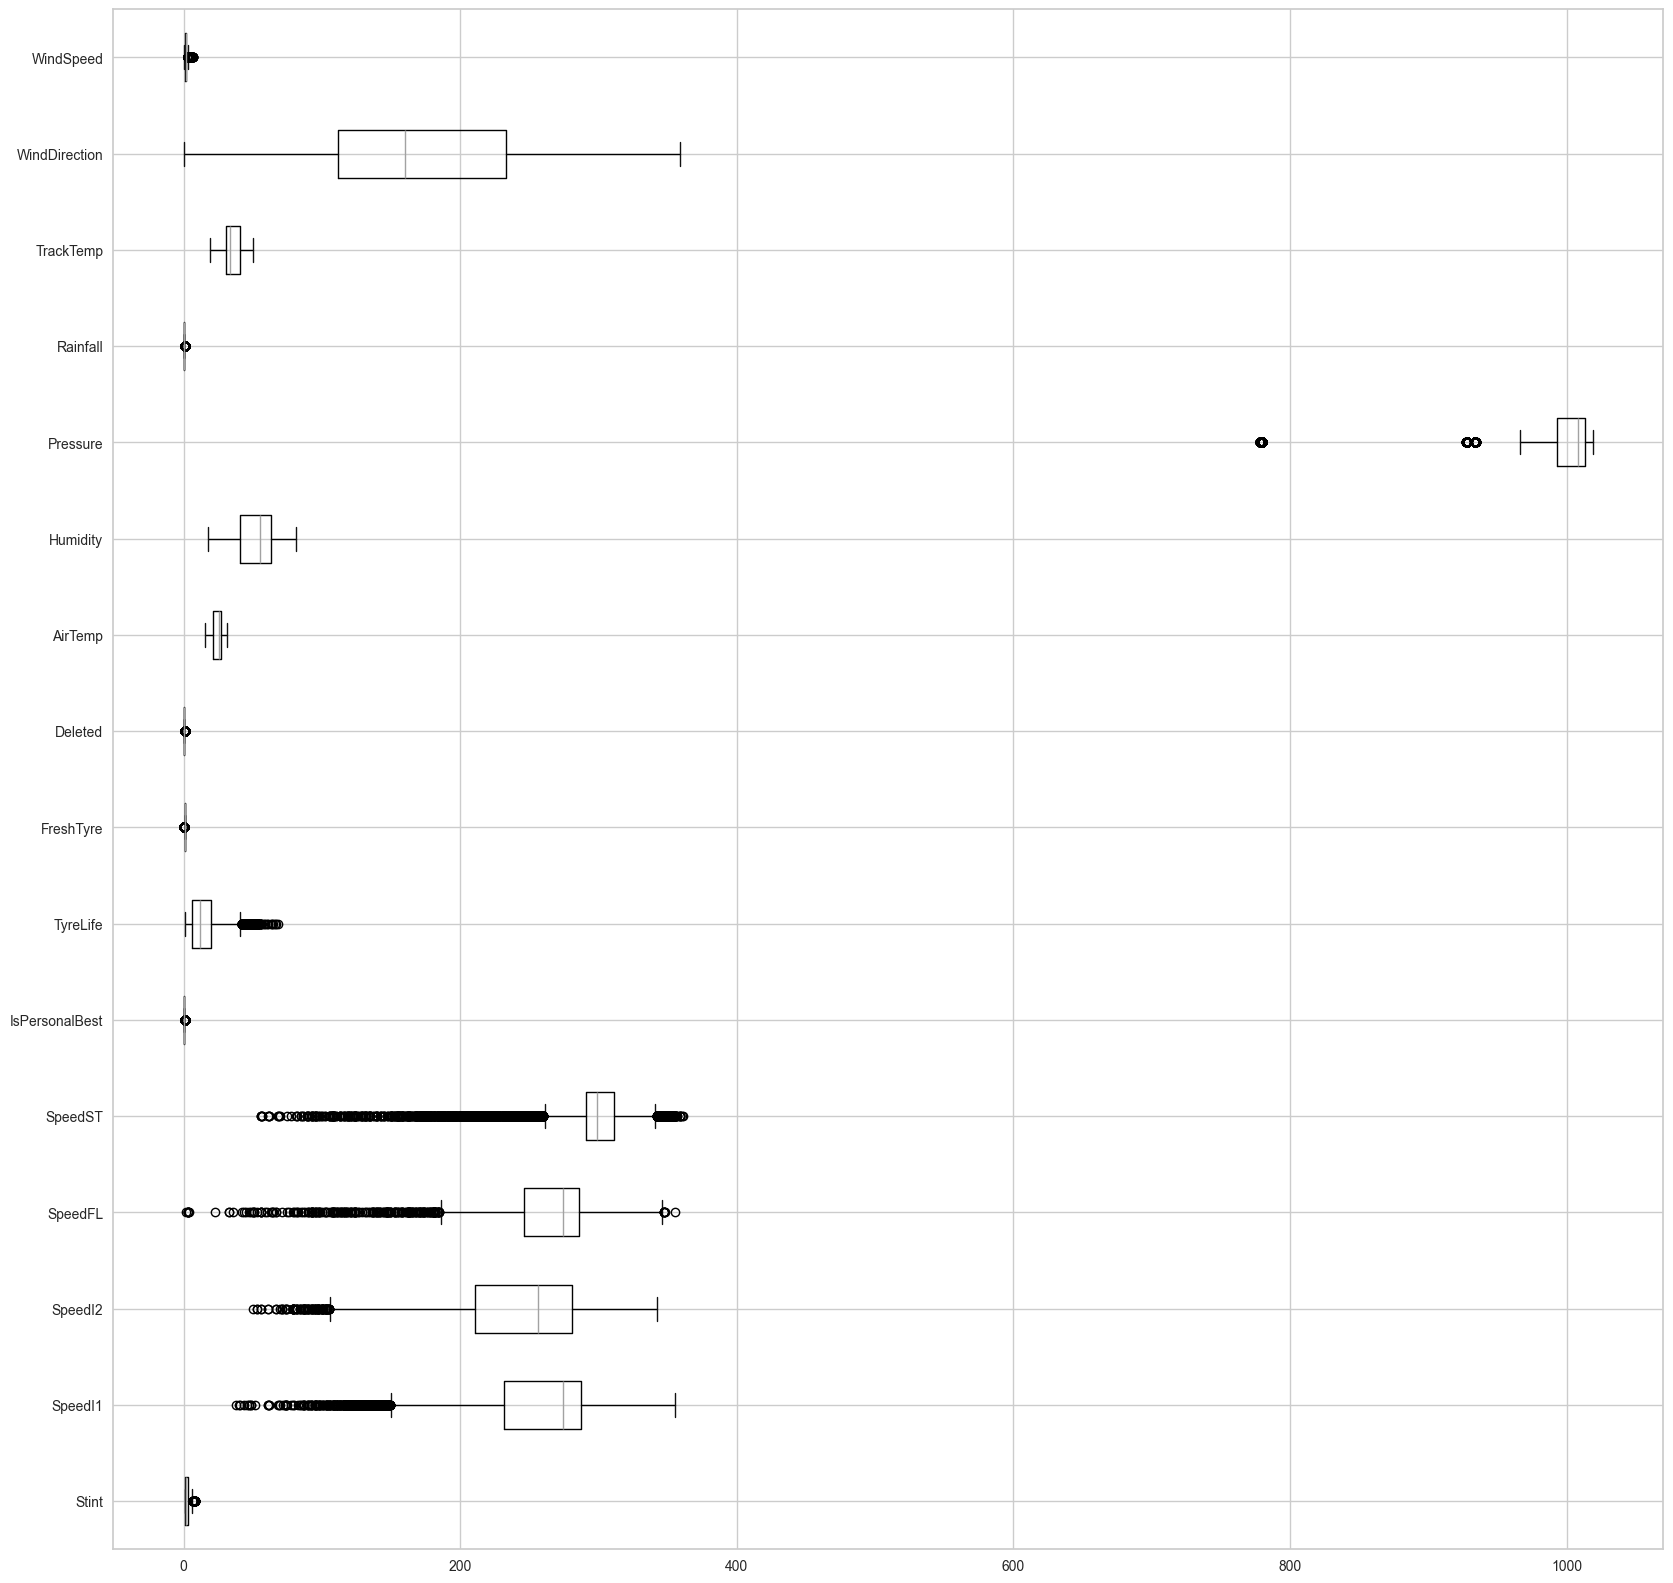

In [186]:
f1_data.boxplot(vert=False,figsize=(20,20))
plt.show()

In [187]:
laptime_numerical = f1_data.select_dtypes(include=['float64', 'int64']) 
Q1 = laptime_numerical.quantile(0.25)
Q3 = laptime_numerical.quantile(0.75)
IQR = Q3 - Q1

In [188]:
print(cek_outlier(f1_data))

Persentase Outlier pada tiap atribut:
Stint             0.298078
SpeedI1           2.746580
SpeedI2           0.548251
SpeedFL           1.320062
SpeedST           7.260340
TyreLife          1.948156
AirTemp           0.000000
Humidity          0.000000
Pressure         15.824772
TrackTemp         0.000000
WindDirection     0.000000
WindSpeed         8.026827
dtype: float64
None


> Atribut `Presure` digunakan untuk memprediksi `TyreLife`, sehingga tidak kami drop .

### Encoding Categorical Attributes

In [189]:
print("Menampilkan nilai unique yang terdapat pada setiap kolom kategorikal")
print('#'*70)
print()
for col in f1_data.select_dtypes(include=object).columns:
    print(col, f": {len(f1_data[col].unique())}", f1_data[col].unique())
    print("\n")

Menampilkan nilai unique yang terdapat pada setiap kolom kategorikal
######################################################################

Time : 18744 ['0 days 02:26:25.496000' '0 days 01:13:51.732000'
 '0 days 02:22:35.139000' ... '0 days 02:00:31.678000'
 '0 days 01:07:59.947000' '0 days 02:04:03.127000']


LapTime : 14761 ['0 days 00:01:40.943000' '0 days 00:01:48.067000'
 '0 days 00:01:22.881000' ... '0 days 00:01:25.235000'
 '0 days 00:01:52.495000' '0 days 00:02:25.892000']


Sector1Time : 11540 ['0 days 00:00:46.163000' '0 days 00:00:39.129000'
 '0 days 00:00:28.890000' ... '0 days 00:01:06.782000'
 '0 days 00:00:30.620000' '0 days 00:00:52.231000']


Sector2Time : 12067 ['0 days 00:00:28.979000' '0 days 00:00:43.601000'
 '0 days 00:00:18.554000' ... '0 days 00:01:09.507000'
 '0 days 00:00:49.567000' '0 days 00:00:53.937000']


Sector3Time : 10711 ['0 days 00:00:25.801000' '0 days 00:00:25.337000'
 '0 days 00:00:35.437000' ... '0 days 00:00:21.484000'
 '0 days 00:00:28.037000

In [190]:
f1_data['Compound'] = f1_data['Compound'].map({'INTERMEDIATE':1, 'MEDIUM':4, 'HARD':2, 'SOFT':3, 'WET':0})
f1_data['Pos_cat'] = f1_data['Pos_cat'].map({'Participant':0, 'Podium':2, 'Point':1})

In [191]:
def zero_days_remover (duration):
    return duration.replace('0 days ', '')

In [192]:
time_att = []
for col in f1_data.select_dtypes(include=object).columns:
    time_att.append(col)

In [193]:
time_att

['Time',
 'LapTime',
 'Sector1Time',
 'Sector2Time',
 'Sector3Time',
 'Sector1SessionTime',
 'Sector2SessionTime',
 'Sector3SessionTime',
 'LapStartTime']

In [194]:
for time in time_att:
    f1_data[time] = f1_data[time].apply(zero_days_remover)

Untuk memudahkan encoding waktu, kami menghilangkan 0 days karena seluruh data memiliki 0 days dan hal tersebut tidak membantu kami dalam melakukan encoding waktu

In [195]:
import datetime
import time


In [196]:
def time_converter (time_str):
    if '.' in time_str:
        time_str, milliseconds = time_str.split('.')
        milliseconds = int(milliseconds)
    else:
        milliseconds = 0

    x_time = datetime.datetime.strptime(time_str, '%H:%M:%S')

    total_seconds = datetime.timedelta(
        hours=x_time.hour,
        minutes=x_time.minute,
        seconds=x_time.second,
        microseconds=milliseconds / 1000  # Convert milliseconds to microseconds
    ).total_seconds()
    
    return total_seconds

In [197]:
for time in time_att:
    f1_data[time] = f1_data[time].apply(time_converter)

In [198]:
boolean_columns = ['IsPersonalBest', 'FreshTyre', 'Deleted', 'Rainfall']
f1_data = pd.get_dummies(f1_data, columns = boolean_columns, drop_first=True) 
f1_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18787 entries, 0 to 18787
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 18787 non-null  float64
 1   LapTime              18787 non-null  float64
 2   Stint                18787 non-null  float64
 3   Sector1Time          18787 non-null  float64
 4   Sector2Time          18787 non-null  float64
 5   Sector3Time          18787 non-null  float64
 6   Sector1SessionTime   18787 non-null  float64
 7   Sector2SessionTime   18787 non-null  float64
 8   Sector3SessionTime   18787 non-null  float64
 9   SpeedI1              18787 non-null  float64
 10  SpeedI2              18787 non-null  float64
 11  SpeedFL              18787 non-null  float64
 12  SpeedST              18787 non-null  float64
 13  Compound             18787 non-null  int64  
 14  TyreLife             18787 non-null  float64
 15  LapStartTime         18787 non-null  floa

# **EKSPLORASI** 

Apakah penggunaan ‘Compound’ yang berbeda berpengaruh terhadap performa? 


Performa dari suatu mobil F1 dapat ditentukan melalui waktu yang ditempuh mobil tersebut selama satu lap, yaitu atribut LapTime. Atribut ini juga kami pilih sebagai representasi performa yang dianalisis pengaruhnya oleh Compound karena dalam balapan F1, tipe compound yang berbeda tidak mungkin dipakai dalam satu lap yang sama. Oleh karena itu pada eksplorasi ini kami hanya mengambil atribut Compound dan LapTime

In [199]:
compount_influence = f1_data.copy()

In [200]:
compount_influence = compount_influence[['Compound', 'LapTime']]
compount_influence

,Compound,LapTime
0,1,100.000943
1,4,108.000067
2,2,82.000881
3,3,91.000585
4,2,94.000742
...,...,...
18783,2,85.000235
18784,4,100.000363
18785,3,112.000495
18786,2,85.000938


In [201]:
compount_influence['Compound'] = compount_influence['Compound'].map({1: 'INTERMEDIATE', 4: 'MEDIUM', 2: 'HARD', 3: 'SOFT', 0: 'WET'})
compount_influence

,Compound,LapTime
0,INTERMEDIATE,100.000943
1,MEDIUM,108.000067
2,HARD,82.000881
3,SOFT,91.000585
4,HARD,94.000742
...,...,...
18783,HARD,85.000235
18784,MEDIUM,100.000363
18785,SOFT,112.000495
18786,HARD,85.000938


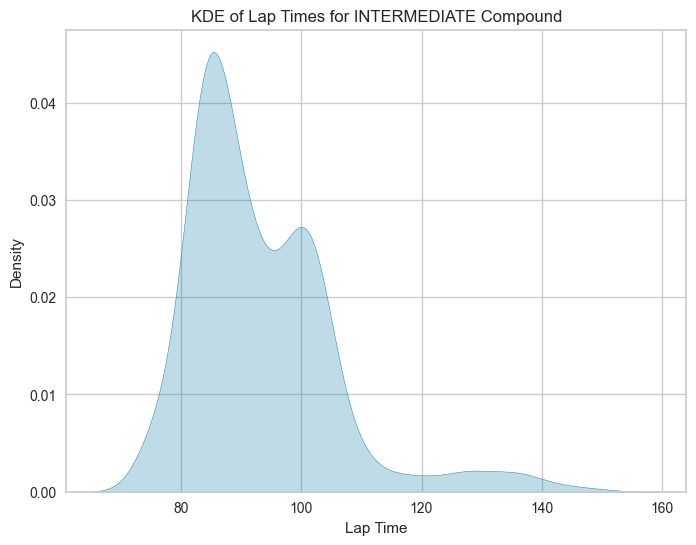

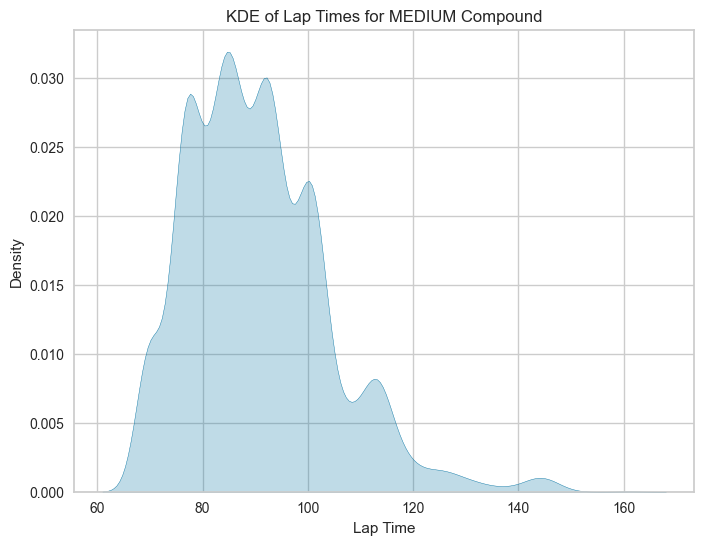

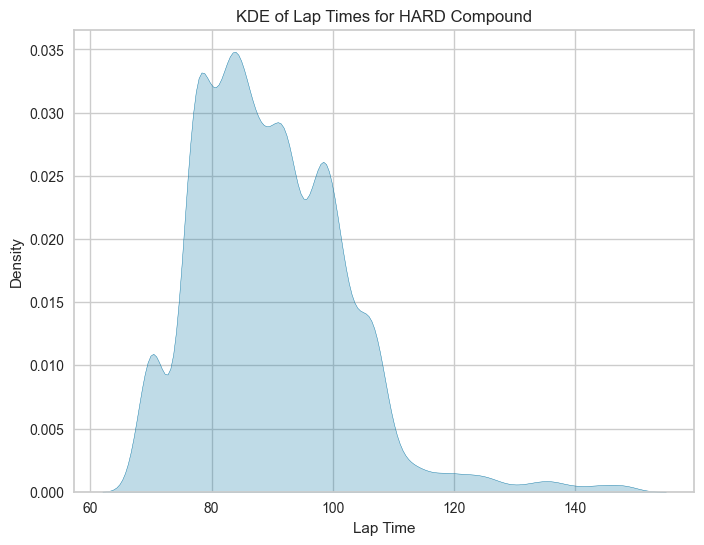

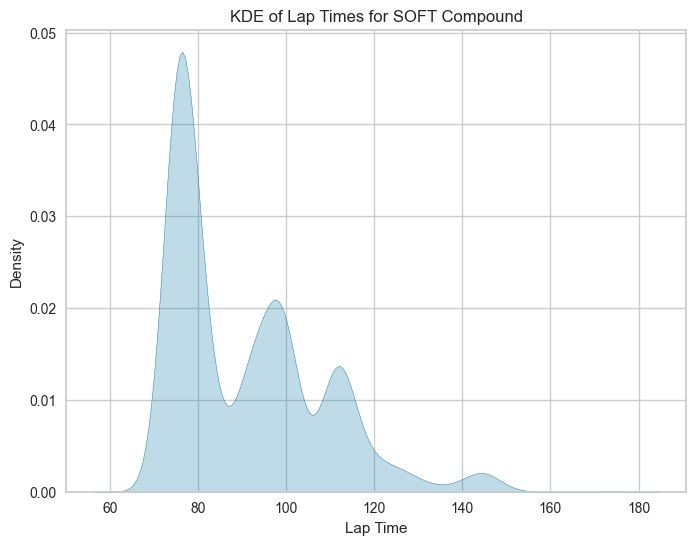

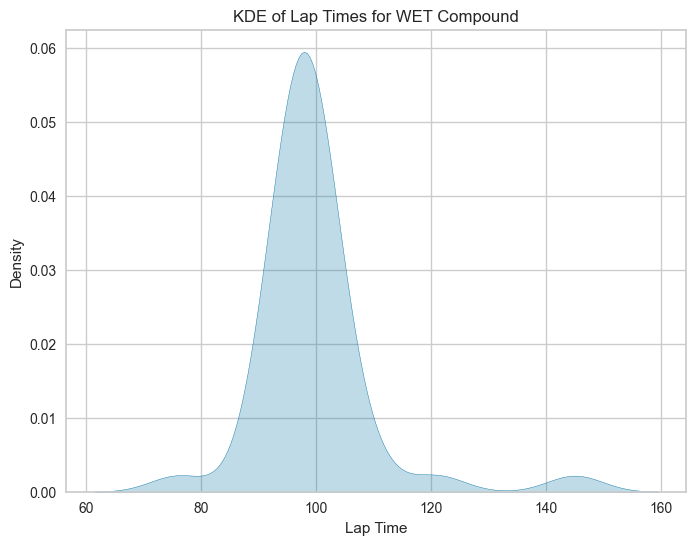

In [202]:
compounds = compount_influence['Compound'].unique()
for compound in compounds:
    plt.figure(figsize=(8, 6))
    subset = compount_influence[compount_influence['Compound'] == compound]['LapTime']
    sns.kdeplot(subset, fill=True)
    plt.title(f'KDE of Lap Times for {compound} Compound')
    plt.xlabel('Lap Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

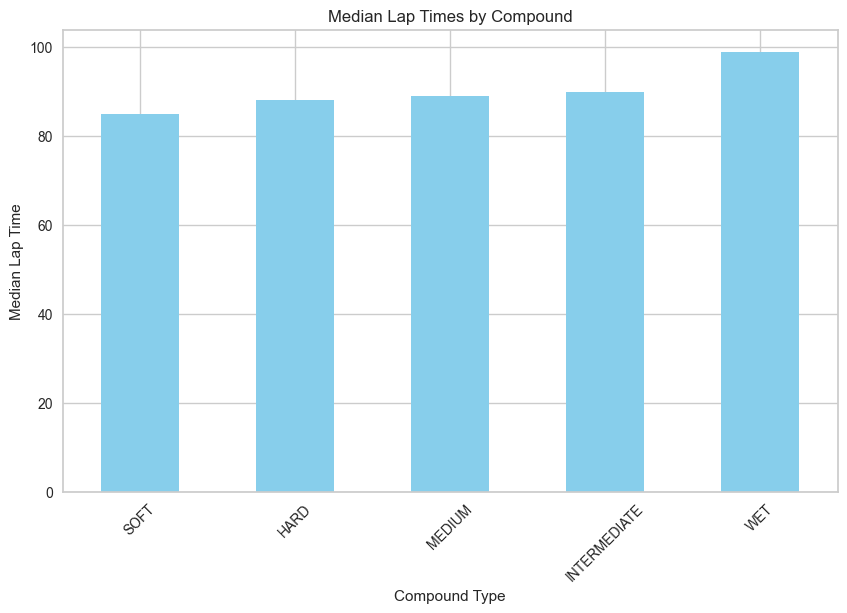

In [203]:
median_laptimes = compount_influence.groupby('Compound')['LapTime'].median()
median_laptimes = median_laptimes.sort_values()
median_laptimes.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Median Lap Times by Compound')
plt.xlabel('Compound Type')
plt.ylabel('Median Lap Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

> Grafik diatas adalah grafik yang menampilkan median LapTime dari setiap Compound dan diurutkan dari LapTime paling cepat hingga LapTime paling lambat

> Berdasarkan visualisasi diatas, dapat dianalisis bahwa setiap tipe Compound dapat mempengaruhi performa mobil F1 karena menghasilkan LapTime yang berbeda-beda. Performa terbaik didapatkan ketika mobil-mobil F1 menggunakan Compound bertipe SOFT. Lalu, diikuti dengan tipe Compound HARD, MEDIUM, & INTERMEDIATE untuk performa terbaik kedua, ketiga, dan keempat. Untuk performa terburuk, didapatkan ketika mobil F1 menggunakan tipe Compound WET.

Bagaimana ciri-ciri driver dengan kategori posisi ‘Pos_cat’ Podium dibandingkan dengan kategori posisi lainnya?


Analisis perbedaan ketika sirkuit hujan ‘Rainfall’ atau tidak


In [204]:
df_rain = f1_data.copy()
mean_attributes = ['LapTime', 'TyreLife', 'AirTemp', 'Humidity', 'TrackTemp','WindSpeed']
mode_attributes = ['Compound']

reverse_compound_mapping = {1: 'INTERMEDIATE', 4: 'MEDIUM', 2: 'HARD', 3: 'SOFT', 0: 'WET'}
df_rain['Compound'] = df_rain['Compound'].map(reverse_compound_mapping)

In [205]:
rainfall_data = df_rain[df_rain['Rainfall_True'] == True]
rainfall_mean = rainfall_data[mean_attributes].median()
rainfall_mode = rainfall_data[mode_attributes].mode().iloc[0]

rainfall_combined = pd.concat([rainfall_mean, rainfall_mode])
rainfall_combined


LapTime         100.00078
TyreLife              7.0
AirTemp              17.5
Humidity             66.0
TrackTemp            27.3
WindSpeed             1.7
Compound     INTERMEDIATE
dtype: object

In [206]:
no_rainfall_data = df_rain[df_rain['Rainfall_True'] == False]
no_rainfall_mean = no_rainfall_data[mean_attributes].median()
no_rainfall_mode = no_rainfall_data[mode_attributes].mode().iloc[0]

no_rainfall_combined = pd.concat([no_rainfall_mean, no_rainfall_mode])
no_rainfall_combined

LapTime      88.0006
TyreLife        12.0
AirTemp         25.6
Humidity        54.0
TrackTemp       34.3
WindSpeed        1.5
Compound        HARD
dtype: object

Di sini, kami akan melakukan perbandingan kondisi balapan ketika sirkuit 'Rainfall' dan tidak dengan asumsi bahwa data ini adalah kumpulan dari balapan-balapan satu musim di lokasi dan waktu yg berbeda. Dari data yang telah diolah, kami menemukan bahwa terdapat beberapa aspek yang berbeda dari sirkuit 'Rainfall' dan tidak.  LapTime dari dua keadaan sirkuit ini berbeda cukup signifikan, di mana dalam keadaan 'Rainfall' diperlukan lebih banyak waktu untuk melakukan 'LapTime' jika dibandingkan dengan track tidak 'Rainfall'. Dari segi 'AirTemp', sirkuit 'Rainfall' memiliki temperatur udara yang lebih rendah. Selain itu, sirkuit 'Rainfall' memiliki temperatur track yang lebih rendah, serta memiliki 'humidity' lebih tinggi jika dibanding track yang tidak 'Rainfall'. Ban Intermediate menjadi ban yang sering dipakai pada sirkuit 'Rainfall'. Di sirkuit yang tidak 'Rainfall', temperatur track lebih tinggi dibanding track 'Rainfall' dan memiliki 'WindDirection' lebih tinggi dibanding track 'Rainfall'. Adapun 'Compound' ban yang sering dipakai untuk sirkuit tidak 'Rainfall' adalah ban berjenis Hard. Kedua tipe sirkuit ini tidak berbeda terlalu jauh jika kita tinjau dari segi 'Pressure' atau tekanan udara.

Adakah rentang umur ban ‘TyreLife’ dengan performa terbaik dibandingkan rentang umur ban lainnya?


# **REGRESI**

In [207]:
# https://medium.com/analytics-vidhya/evaluation-metrics-for-regression-models-c91c65d73af
def regression_metrics(prediction, y_test):
    MAE = mean_absolute_error(y_test, prediction)
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    R_squared = r2_score(y_test, prediction)

    print('MAE: ' + str(MAE))
    print('MSE: ' + str(MSE))
    print('RMSE: ' + str(RMSE))
    print('R_squared: ' + str(R_squared))

In [208]:
# Split dan seleksi fitur Dataset Klasifikasi
X_regression = f1_data.drop(columns=['TyreLife'], axis=1)
y_regression = f1_data['TyreLife']

In [209]:
X_regress_train, X_regress_test, y_regress_train, y_regress_test = train_test_split(X_regression, y_regression, test_size=0.3, random_state=42)

In [210]:
#Standarisasi
scaler = MinMaxScaler()

X_regress_train = scaler.fit_transform(X_regress_train)
X_regress_test = scaler.transform(X_regress_test)

## **Random Forest**

In [211]:
# Random Forest
rf_f1 = RandomForestRegressor()
rf_f1.fit(X_regress_train, y_regress_train)

# Memprediksi data testing
predicted = rf_f1.predict(X_regress_test)
regression_metrics(predicted, y_regress_test)

MAE: 1.7536295902075572
MSE: 9.710166949086393
RMSE: 3.116114078317158
R_squared: 0.9072071083531434


In [212]:
alpha_f1 = [0.01, 0.1, 1, 10, 100]

## **Ridge Regression**

In [213]:
ridge_model_f1 = []
for alpha in alpha_f1:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_regress_train, y_regress_train)
    ridge_model_f1.append(ridge)

In [214]:
from sklearn import metrics
metrics_list = []
counter = 1
for model in ridge_model_f1:
    y_pred = model.predict(X_regress_test)
    mse = metrics.mean_squared_error(y_regress_test, y_pred)
    mae = metrics.mean_absolute_error(y_regress_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = metrics.r2_score(y_regress_test, y_pred)
    
    metrics_list.append((alpha_f1[counter-1], mse, mae, rmse, r2))
    
    print(f'Model Ridge regression ke {counter}')
    print("MSE:", mse)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R-squared:", r2)
    print()
    counter += 1

# Find the best model based on RMSE (you can change the criteria if needed)
best_model_idx = max(range(len(metrics_list)), key=lambda i: metrics_list[i][4])  # Using R-squared for selection
best_model = ridge_model_f1[best_model_idx]

print(f'Model terbaik adalah model ke-{best_model_idx + 1} dengan alpha={metrics_list[best_model_idx][0]}')
print(f'Metrik Evaluasi - MSE: {metrics_list[best_model_idx][1]}, MAE: {metrics_list[best_model_idx][2]}, RMSE: {metrics_list[best_model_idx][3]}, R-squared: {metrics_list[best_model_idx][4]}')

Model Ridge regression ke 1
MSE: 47.179895336752274
MAE: 5.195211196230772
RMSE: 6.868762285648869
R-squared: 0.5491365968424263

Model Ridge regression ke 2
MSE: 47.1861164317603
MAE: 5.1955252766189375
RMSE: 6.869215124871276
R-squared: 0.5490771464335888

Model Ridge regression ke 3
MSE: 47.239374166427126
MAE: 5.1978205928460515
RMSE: 6.873090583313094
R-squared: 0.5485682016102702

Model Ridge regression ke 4
MSE: 47.55797441237136
MAE: 5.218315463759714
RMSE: 6.896228999414924
R-squared: 0.5455235744421095

Model Ridge regression ke 5
MSE: 54.237469375917115
MAE: 5.611019269142896
RMSE: 7.364609248012899
R-squared: 0.48169257589616366

Model terbaik adalah model ke-1 dengan alpha=0.01
Metrik Evaluasi - MSE: 47.179895336752274, MAE: 5.195211196230772, RMSE: 6.868762285648869, R-squared: 0.5491365968424263


# **KLASIFIKASI**

In [215]:
# Split Dataset Klasifikasi
X_classification = f1_data.drop(columns=['Pos_cat'], axis=1)
y_classification = f1_data['Pos_cat']

In [216]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_classification, y_classification, test_size=0.3, random_state=42)

In [217]:
#Standarisasi
scaler = MinMaxScaler()

X_class_train = scaler.fit_transform(X_class_train)
X_class_test = scaler.transform(X_class_test)

In [218]:
# Decision Tree  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def classification_metrics(prediction, y_test):
    print(f'Accuracy: {accuracy_score(y_test, prediction)}')
    print('F1 Macro Average:', f1_score(y_test, prediction, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, prediction, average='micro'))
    print('Precision Macro Average:', precision_score(y_test, prediction, average='macro',zero_division=0))
    print('Precision Micro Average:', precision_score(y_test, prediction, average='micro',zero_division=0))
    print('Recall Macro Average:', recall_score(y_test, prediction, average='macro',zero_division=0))
    print('Recall Micro Average:', recall_score(y_test, prediction, average='micro',zero_division=0))
    print()

## **Random Forest**

In [219]:
# Random Forest
rf_f1 = RandomForestClassifier()
rf_f1.fit(X_class_train, y_class_train)

RandomForestClassifier()

In [220]:
# Memprediksi data testing
predicted = rf_f1.predict(X_class_test)
classification_metrics(predicted, y_class_test)

Accuracy: 0.8009579563597659
F1 Macro Average: 0.7808407544105106
F1 Micro Average: 0.800957956359766
Precision Macro Average: 0.8080234973229454
Precision Micro Average: 0.8009579563597659
Recall Macro Average: 0.7638687590915603
Recall Micro Average: 0.8009579563597659



# **Clustering**

## **PCA**

In [221]:
pca = PCA()
df_f1_pca = f1_data.copy()
df_f1_pca.head()

,Time,LapTime,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,...,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Pos_cat,IsPersonalBest_True,FreshTyre_True,Deleted_True,Rainfall_True
0,8785.000496,100.000943,6.0,46.000163,28.000979,25.000801,8736.000926,8765.000905,8791.000706,283.0,...,68.0,1008.0,24.8,157,3.0,0,False,False,False,False
1,4431.000732,108.000067,1.0,39.000129,43.000601,25.000337,4362.000794,4406.000395,4431.000732,199.0,...,49.0,1008.5,43.3,275,1.0,2,False,True,False,False
2,8555.000139,82.000881,2.0,28.000890,18.000554,35.000437,8501.000150,8519.000704,8555.000141,275.0,...,57.0,1018.2,29.9,0,0.6,0,True,True,False,False
3,3816.000822,91.000585,1.0,28.000315,28.000929,30.000478,3898.000279,3786.000412,3816.000927,266.0,...,67.0,1007.7,29.5,135,1.8,2,False,True,False,False
4,6340.000072,94.000742,2.0,34.000895,29.000874,29.000973,6280.000174,6310.000048,6340.000021,274.0,...,55.0,1011.0,31.0,271,1.3,1,False,True,False,False


In [222]:
scaler = MinMaxScaler()
f1_pca_std = scaler.fit_transform(df_f1_pca)

In [223]:
pca.fit(f1_pca_std)

PCA()

In [224]:
pca.explained_variance_ratio_

array([1.91070404e-01, 1.51576595e-01, 1.13880230e-01, 1.09471966e-01,
       9.01460451e-02, 6.63181698e-02, 5.10035618e-02, 4.32219377e-02,
       3.44537980e-02, 2.23372424e-02, 2.13345464e-02, 1.74098193e-02,
       1.59561298e-02, 1.46168515e-02, 1.33864321e-02, 1.05767777e-02,
       8.87192500e-03, 6.89848362e-03, 4.51860288e-03, 3.98488125e-03,
       2.94525996e-03, 2.58964780e-03, 1.61667675e-03, 8.88265000e-04,
       7.22305314e-04, 1.78923474e-04, 2.45220876e-05])

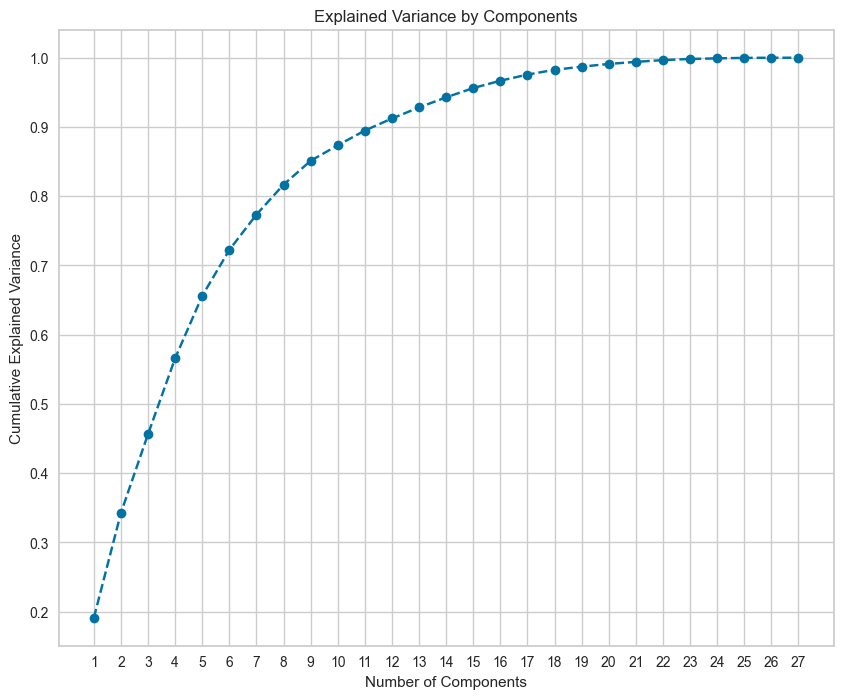

In [225]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 28), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, 28)) 
plt.show()

In [226]:
pca = PCA(n_components = 8)
pca.fit(f1_pca_std)

PCA(n_components=8)

In [227]:
scores_pca = pca.transform(df_f1_pca)
scores_pca

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


array([[15415.33376695, -5002.08387567,  6085.49617644, ...,
         -577.83928661,   438.10637875, -2594.03619896],
       [ 7689.29157779, -2564.57618279,  3114.19774225, ...,
         -381.99878708,   -92.83300313, -1540.04587973],
       [15009.01530797, -4873.98120756,  5931.84237265, ...,
         -655.04837002,   512.7033563 , -2542.89625842],
       ...,
       [12641.7770218 , -4125.23870942,  5007.7174962 , ...,
         -524.69642986,   309.24130653, -2186.85245959],
       [ 7083.76609025, -2364.07132891,  2874.57999365, ...,
         -419.47210975,   -25.85453495, -1456.43825273],
       [12981.16909288, -4247.70486265,  5129.84959651, ...,
         -542.84213996,   232.62581097, -2201.28573295]])

In [228]:
WCSS = []
for i in range(1,28):
  kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
  kmeans_pca.fit(scores_pca)
  WCSS.append(kmeans_pca.inertia_)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

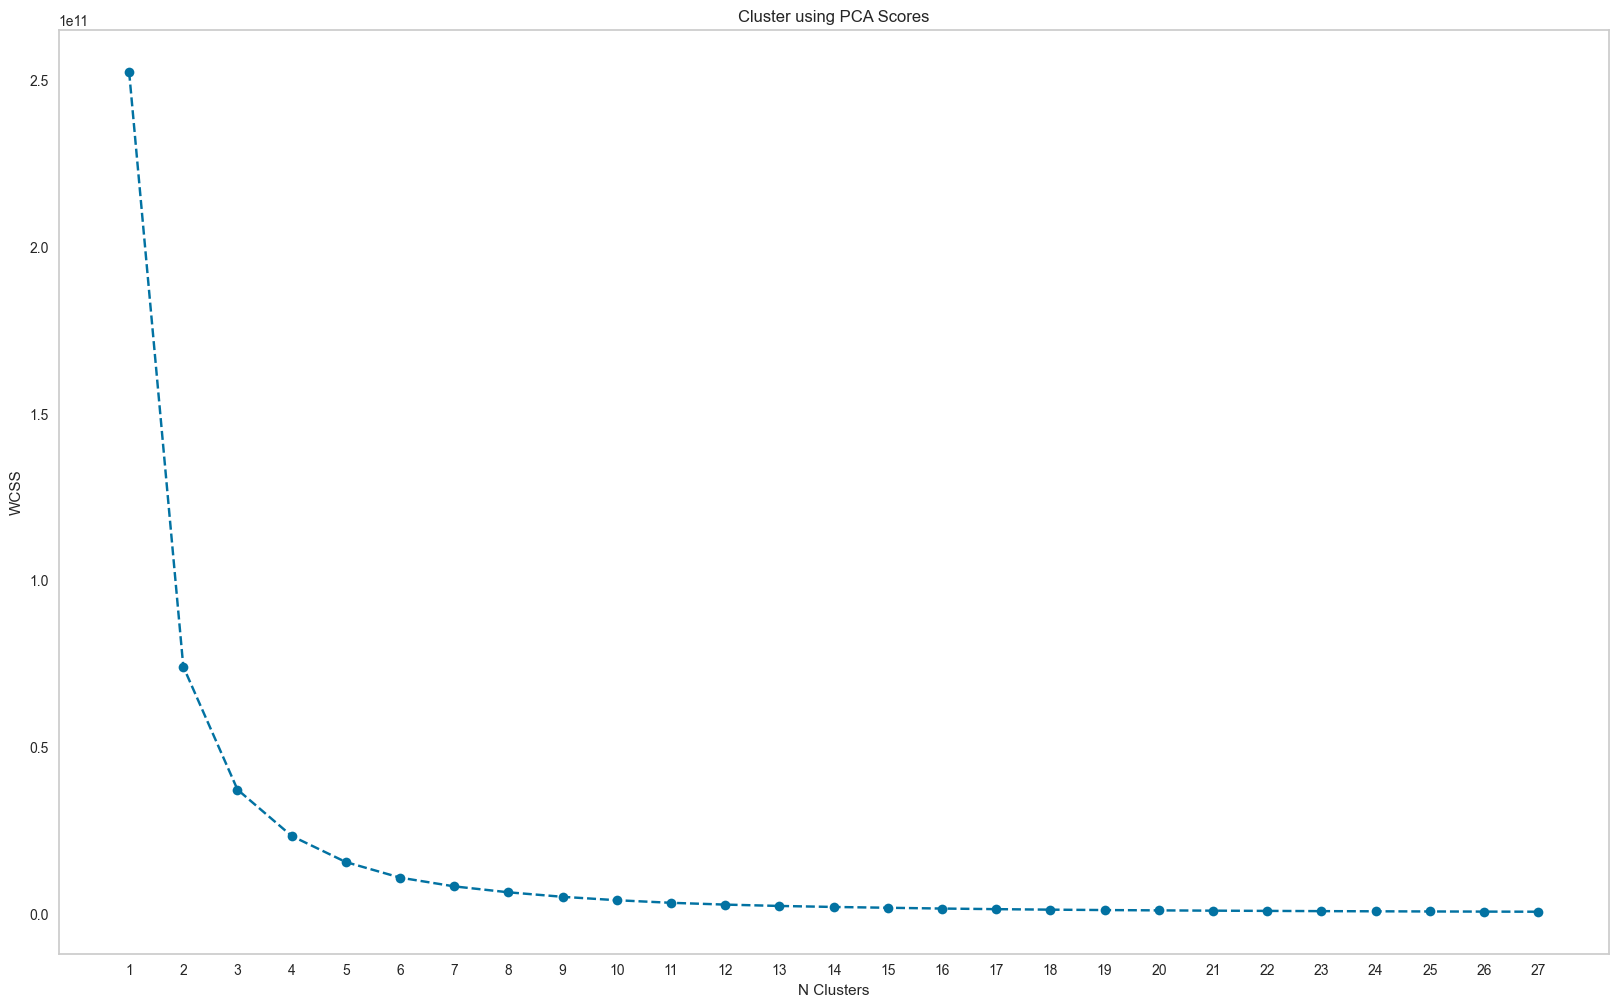

In [229]:
plt.figure(figsize = (20,12))
plt.plot(range(1,28), WCSS, marker = "o", linestyle = "--")
plt.grid()
plt.title("Cluster using PCA Scores")
plt.ylabel("WCSS")
plt.xlabel("N Clusters")
plt.xticks(range(1, 28))  # Setting x-axis ticks to show every component number
plt.show()

In [230]:
kmeans_pca = KMeans(n_clusters = 3, init = "k-means++", random_state = 42)
kmeans_pca.fit(scores_pca)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [231]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df_f1_pca.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-8:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

df_segm_pca_kmeans


,Time,LapTime,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,...,Rainfall_True,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment K-means PCA
0,8785.000496,100.000943,6.0,46.000163,28.000979,25.000801,8736.000926,8765.000905,8791.000706,283.0,...,False,15415.333767,-5002.083876,6085.496176,-849.091625,-5660.608612,-577.839287,438.106379,-2594.036199,1
1,4431.000732,108.000067,1.0,39.000129,43.000601,25.000337,4362.000794,4406.000395,4431.000732,199.0,...,False,7689.291578,-2564.576183,3114.197742,-448.011298,-2756.093711,-381.998787,-92.833003,-1540.045880,0
2,8555.000139,82.000881,2.0,28.000890,18.000554,35.000437,8501.000150,8519.000704,8555.000141,275.0,...,False,15009.015308,-4873.981208,5931.842373,-827.275474,-5513.860033,-655.048370,512.703356,-2542.896258,1
3,3816.000822,91.000585,1.0,28.000315,28.000929,30.000478,3898.000279,3786.000412,3816.000927,266.0,...,False,6660.765395,-2246.870255,2731.184572,-397.213289,-2346.071720,-422.441721,-61.561962,-1419.426912,0
4,6340.000072,94.000742,2.0,34.000895,29.000874,29.000973,6280.000174,6310.000048,6340.000021,274.0,...,False,11080.466284,-3629.047204,4421.338353,-622.535840,-4029.261479,-412.926706,98.437007,-2036.584443,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18782,5220.000913,85.000235,2.0,30.000620,30.000668,23.000947,5166.000294,5196.000962,5220.000909,276.0,...,False,9105.246504,-2997.150018,3646.507771,-517.269652,-3304.345424,-387.308207,14.171270,-1732.569449,0
18783,4892.000309,100.000363,1.0,29.000488,42.000838,28.000037,4821.000469,4864.000307,4892.000344,297.0,...,False,8508.801529,-2824.370719,3435.061983,-491.929819,-3059.217573,-446.185571,39.567391,-1685.077400,0
18784,7231.000678,112.000495,3.0,32.000659,49.000567,30.000269,7151.000871,7201.000438,7231.000707,309.0,...,False,12641.777022,-4125.238709,5007.717496,-703.042629,-4625.182396,-524.696430,309.241307,-2186.852460,2
18785,4079.000947,85.000938,1.0,30.000564,31.000370,24.000004,4024.000556,4055.000926,4079.000930,256.0,...,False,7083.766090,-2364.071329,2874.579994,-414.995337,-2543.882536,-419.472110,-25.854535,-1456.438253,0


In [232]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'first', 1: 'second', 2: 'third'})
df_segm_pca_kmeans

,Time,LapTime,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,...,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment K-means PCA,Segment
0,8785.000496,100.000943,6.0,46.000163,28.000979,25.000801,8736.000926,8765.000905,8791.000706,283.0,...,15415.333767,-5002.083876,6085.496176,-849.091625,-5660.608612,-577.839287,438.106379,-2594.036199,1,second
1,4431.000732,108.000067,1.0,39.000129,43.000601,25.000337,4362.000794,4406.000395,4431.000732,199.0,...,7689.291578,-2564.576183,3114.197742,-448.011298,-2756.093711,-381.998787,-92.833003,-1540.045880,0,first
2,8555.000139,82.000881,2.0,28.000890,18.000554,35.000437,8501.000150,8519.000704,8555.000141,275.0,...,15009.015308,-4873.981208,5931.842373,-827.275474,-5513.860033,-655.048370,512.703356,-2542.896258,1,second
3,3816.000822,91.000585,1.0,28.000315,28.000929,30.000478,3898.000279,3786.000412,3816.000927,266.0,...,6660.765395,-2246.870255,2731.184572,-397.213289,-2346.071720,-422.441721,-61.561962,-1419.426912,0,first
4,6340.000072,94.000742,2.0,34.000895,29.000874,29.000973,6280.000174,6310.000048,6340.000021,274.0,...,11080.466284,-3629.047204,4421.338353,-622.535840,-4029.261479,-412.926706,98.437007,-2036.584443,2,third
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18782,5220.000913,85.000235,2.0,30.000620,30.000668,23.000947,5166.000294,5196.000962,5220.000909,276.0,...,9105.246504,-2997.150018,3646.507771,-517.269652,-3304.345424,-387.308207,14.171270,-1732.569449,0,first
18783,4892.000309,100.000363,1.0,29.000488,42.000838,28.000037,4821.000469,4864.000307,4892.000344,297.0,...,8508.801529,-2824.370719,3435.061983,-491.929819,-3059.217573,-446.185571,39.567391,-1685.077400,0,first
18784,7231.000678,112.000495,3.0,32.000659,49.000567,30.000269,7151.000871,7201.000438,7231.000707,309.0,...,12641.777022,-4125.238709,5007.717496,-703.042629,-4625.182396,-524.696430,309.241307,-2186.852460,2,third
18785,4079.000947,85.000938,1.0,30.000564,31.000370,24.000004,4024.000556,4055.000926,4079.000930,256.0,...,7083.766090,-2364.071329,2874.579994,-414.995337,-2543.882536,-419.472110,-25.854535,-1456.438253,0,first


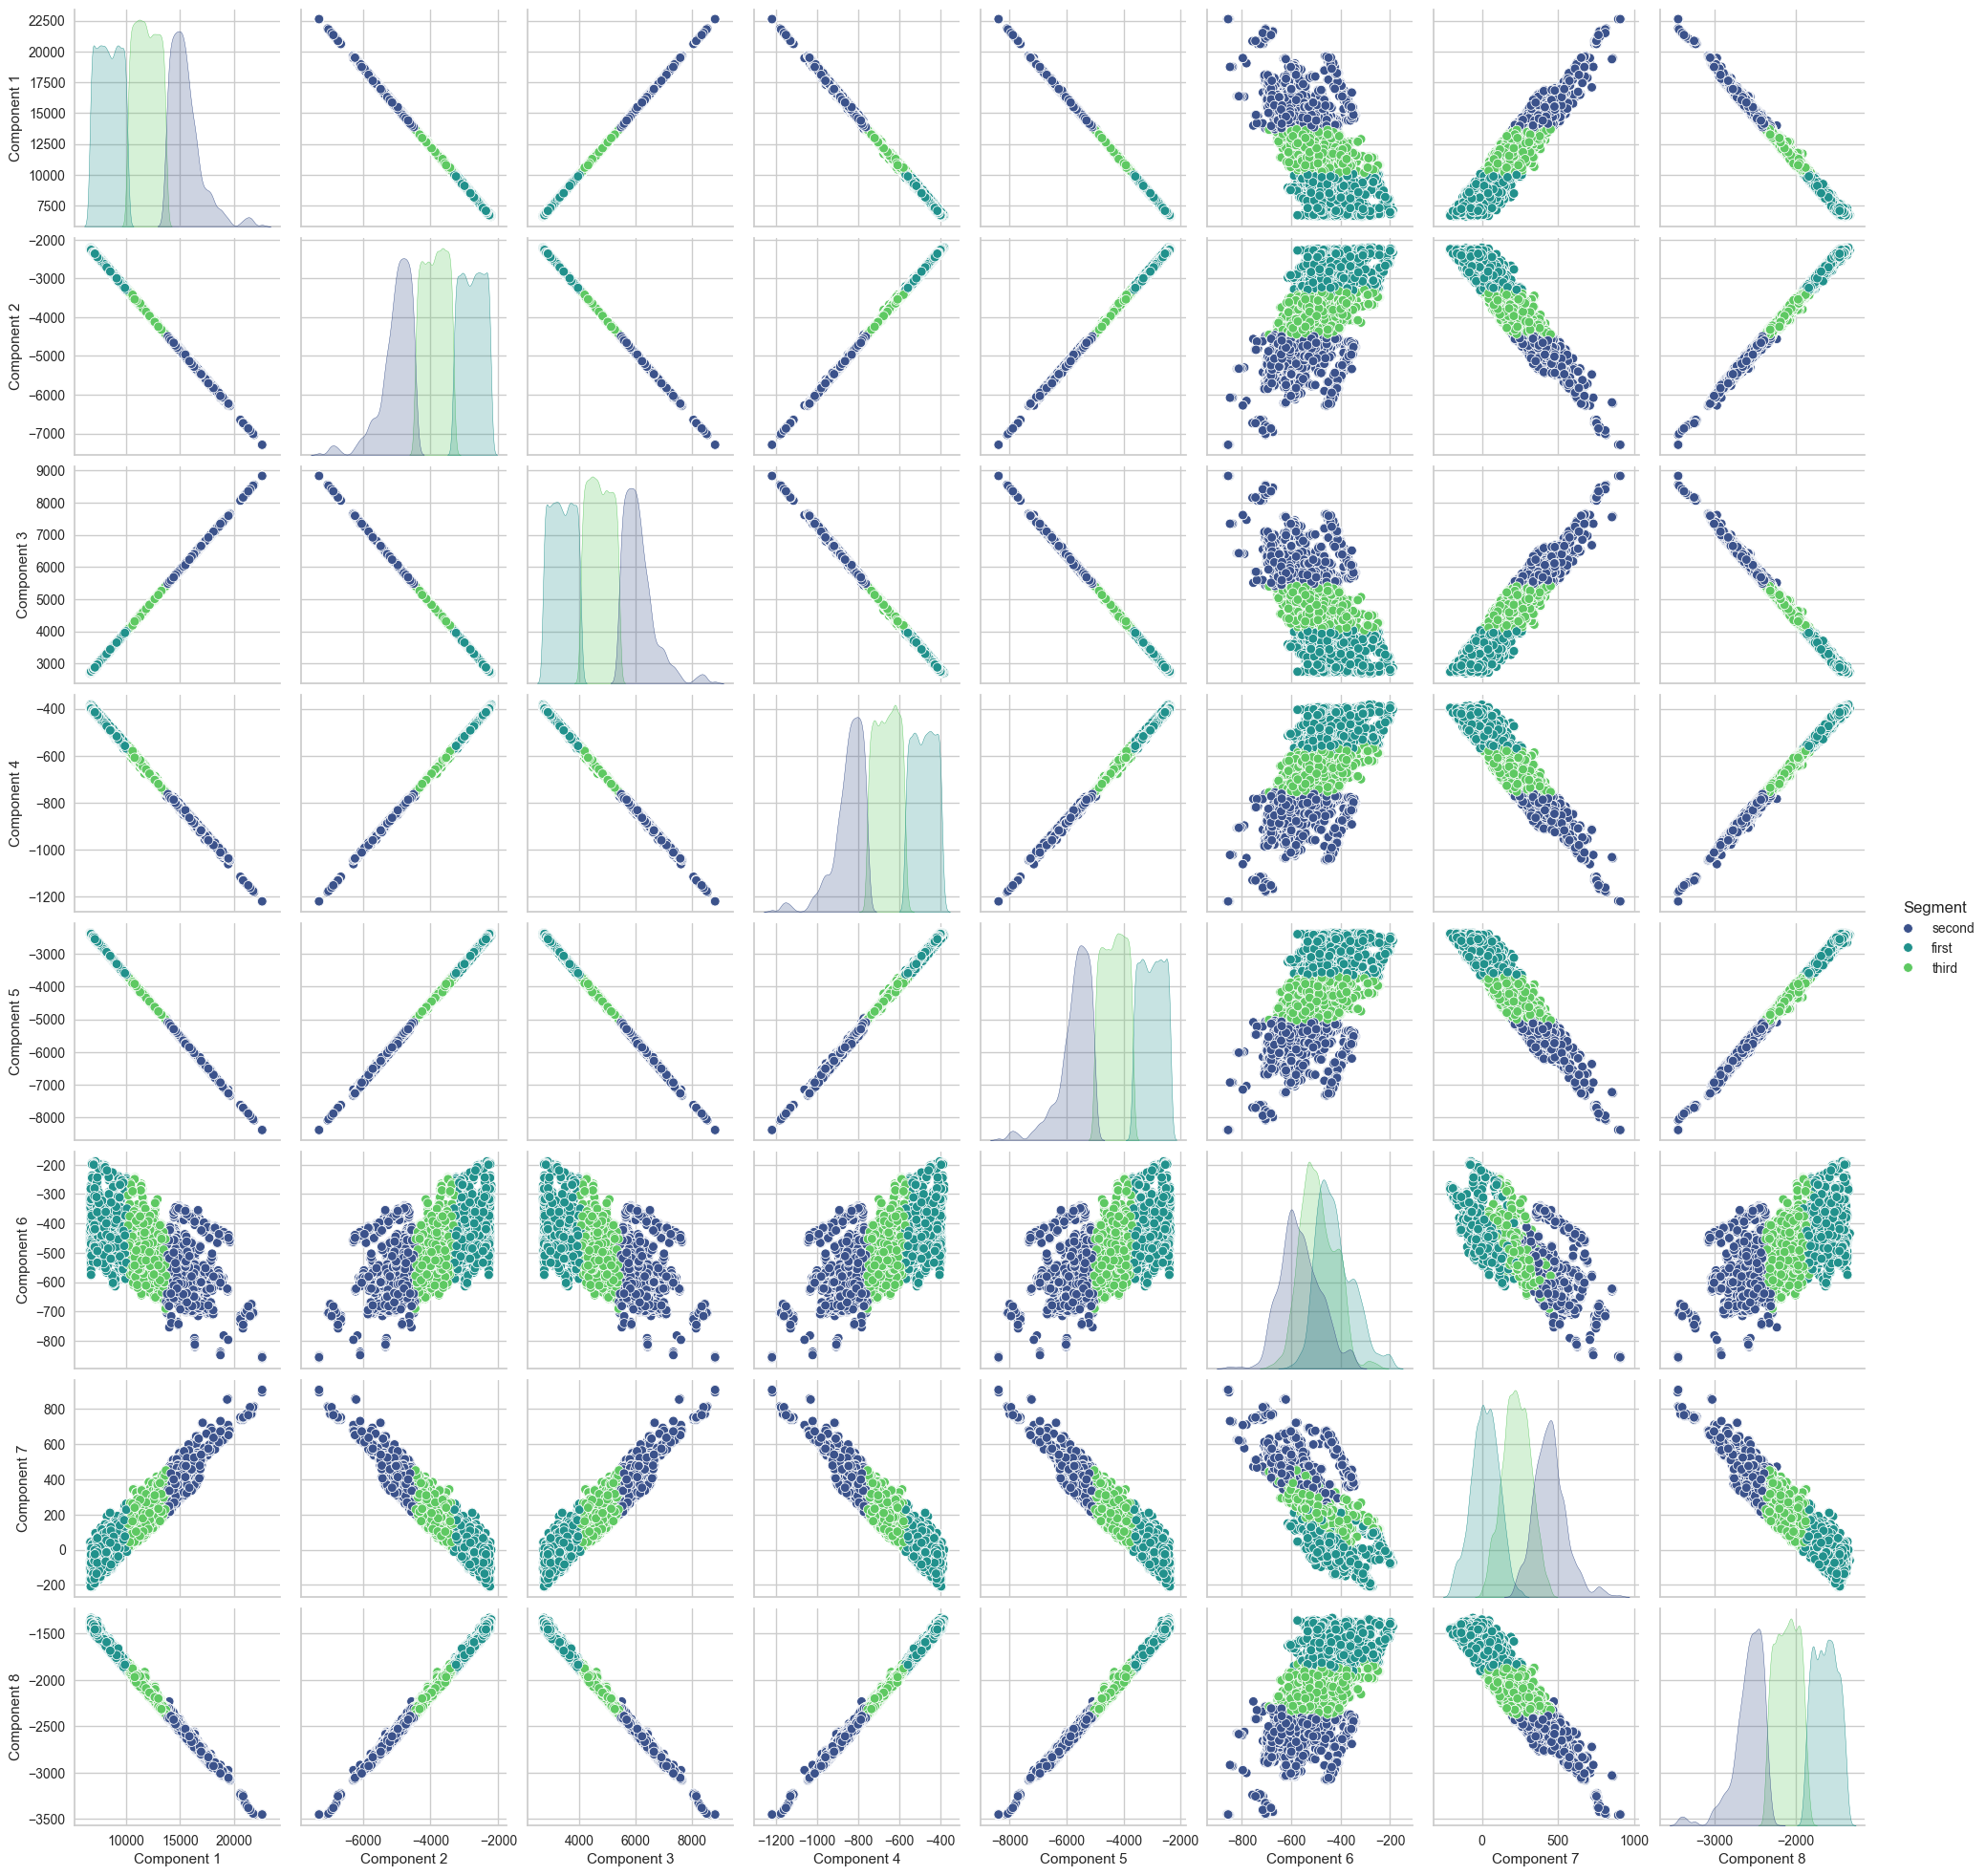

In [233]:
# Use seaborn's pairplot to visualize relationships between each pair of components
sns.pairplot(df_segm_pca_kmeans, vars=['Component 1', 'Component 2', 'Component 3', 'Component 4', 
                                       'Component 5', 'Component 6', 'Component 7', 'Component 8'], 
             hue='Segment', palette='viridis')
plt.show()